# Loading Data

In [96]:
import numpy as np

def get_data():
    data = np.genfromtxt('data.csv', delimiter=',')
    X = data[:, 0]
    Y = data[:, 1]
    return X, Y

In [97]:
import json

def load(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs, targets

def get_data():
    return load("data.json")

def get_data():
    return np.load("X_original.npy"), np.load("y_original.npy")

# Neural Network

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [99]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [100]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(inputs.shape[1] * inputs.shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

In [101]:
inputs, targets = get_data()

model = NeuralNetwork(inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)

train_dataset = TensorDataset(torch.tensor(input_train, dtype=torch.float32), 
                              torch.tensor(target_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(input_test, dtype=torch.float32), 
                             torch.tensor(target_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

history_nn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_nn["loss"].append(train_loss)
    history_nn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    history_nn["val_loss"].append(val_loss)
    history_nn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.2264, Accuracy: 0.2263, Val Loss: 2.1946, Val Accuracy: 0.2633
Epoch 2/50, Loss: 2.1603, Accuracy: 0.2947, Val Loss: 2.1497, Val Accuracy: 0.3091
Epoch 3/50, Loss: 2.1621, Accuracy: 0.2935, Val Loss: 2.1586, Val Accuracy: 0.2963
Epoch 4/50, Loss: 2.1489, Accuracy: 0.3079, Val Loss: 2.1406, Val Accuracy: 0.3158
Epoch 5/50, Loss: 2.1052, Accuracy: 0.3550, Val Loss: 2.1109, Val Accuracy: 0.3488
Epoch 6/50, Loss: 2.0803, Accuracy: 0.3798, Val Loss: 2.0982, Val Accuracy: 0.3616
Epoch 7/50, Loss: 2.0513, Accuracy: 0.4063, Val Loss: 2.0899, Val Accuracy: 0.3650
Epoch 8/50, Loss: 2.0386, Accuracy: 0.4222, Val Loss: 2.0914, Val Accuracy: 0.3670
Epoch 9/50, Loss: 2.0199, Accuracy: 0.4361, Val Loss: 2.0691, Val Accuracy: 0.3859
Epoch 10/50, Loss: 1.9996, Accuracy: 0.4606, Val Loss: 2.0629, Val Accuracy: 0.3946
Epoch 11/50, Loss: 1.9956, Accuracy: 0.4644, Val Loss: 2.0557, Val Accuracy: 0.4020
Epoch 12/50, Loss: 1.9757, Accuracy: 0.4848, Val Loss: 2.0487, Val Accuracy: 0.4141
E

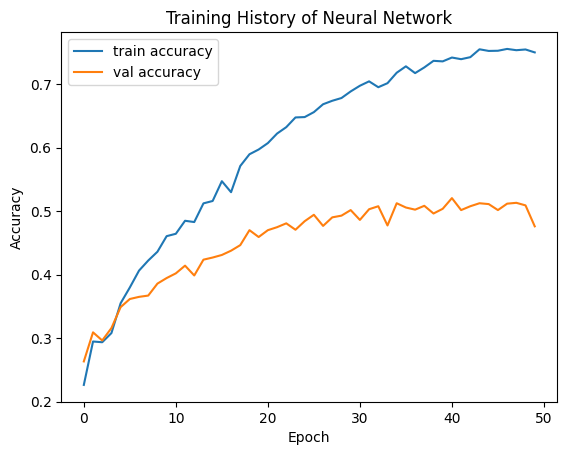

In [102]:
plt.plot(history_nn["accuracy"], label="train accuracy")
plt.plot(history_nn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

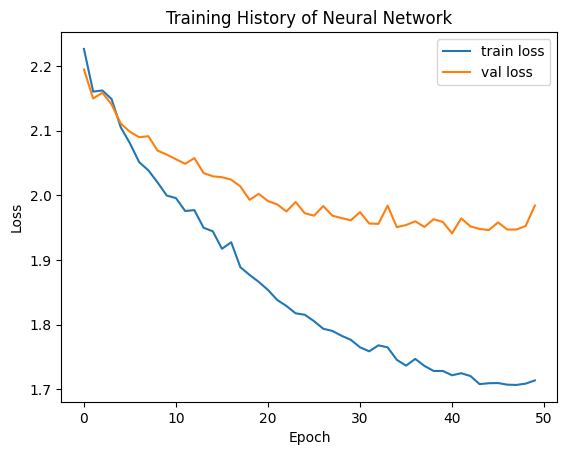

In [103]:
plt.plot(history_nn["loss"], label="train loss")
plt.plot(history_nn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

In [104]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_nn = correct / total
print(f"Test accuracy: {test_accuracy_nn}")

Test accuracy: 0.47609427609427607


# Convolutional Neural Network

In [105]:
class CNN(nn.Module):
    def __init__(self, inputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 2))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 16, kernel_size=(1, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 1), stride=(2, 2), padding=0)
        self.bn4 = nn.BatchNorm2d(16)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2**int(np.log2(inputs.shape[1])), 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool4(self.relu(self.conv4(x)))
        x = self.bn4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [106]:
X, y = get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

model = CNN(X).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 50
history_cnn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        inputs = inputs.squeeze(-1)  # Removes the last dimension of size 1
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_cnn["loss"].append(train_loss)
    history_cnn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history_cnn["val_loss"].append(val_loss)
    history_cnn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.0863, Accuracy: 0.2543, Val Loss: 1.8217, Val Accuracy: 0.3580
Epoch 2/50, Loss: 1.7268, Accuracy: 0.4092, Val Loss: 1.5694, Val Accuracy: 0.4738
Epoch 3/50, Loss: 1.5374, Accuracy: 0.4688, Val Loss: 1.4200, Val Accuracy: 0.5087
Epoch 4/50, Loss: 1.3955, Accuracy: 0.5150, Val Loss: 1.2980, Val Accuracy: 0.5397
Epoch 5/50, Loss: 1.2702, Accuracy: 0.5662, Val Loss: 1.2099, Val Accuracy: 0.5639
Epoch 6/50, Loss: 1.1875, Accuracy: 0.5864, Val Loss: 1.1291, Val Accuracy: 0.6057
Epoch 7/50, Loss: 1.1206, Accuracy: 0.6100, Val Loss: 1.1050, Val Accuracy: 0.6057
Epoch 8/50, Loss: 1.0591, Accuracy: 0.6406, Val Loss: 1.0578, Val Accuracy: 0.6312
Epoch 9/50, Loss: 1.0029, Accuracy: 0.6639, Val Loss: 1.0591, Val Accuracy: 0.6285
Epoch 10/50, Loss: 0.9426, Accuracy: 0.6814, Val Loss: 0.9805, Val Accuracy: 0.6447
Epoch 11/50, Loss: 0.9164, Accuracy: 0.6871, Val Loss: 0.9334, Val Accuracy: 0.6824
Epoch 12/50, Loss: 0.8736, Accuracy: 0.7026, Val Loss: 0.9281, Val Accuracy: 0.6851
E

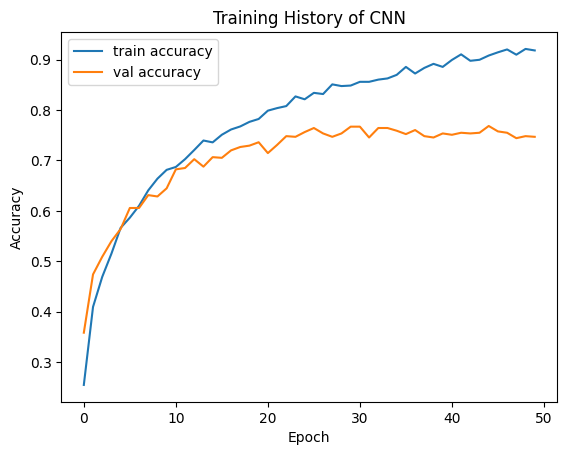

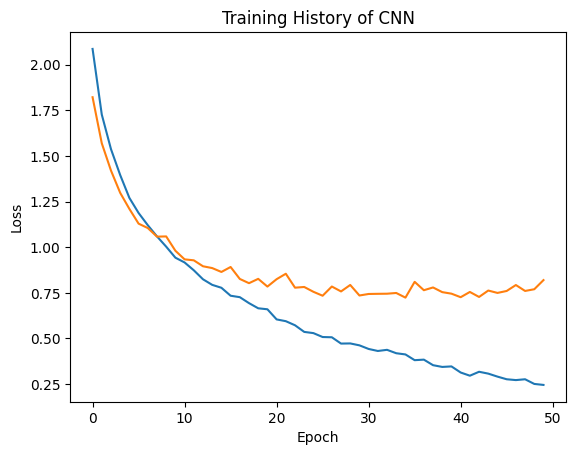

In [107]:
plt.plot(history_cnn["accuracy"], label="train accuracy")
plt.plot(history_cnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend()
plt.show()

plt.plot(history_cnn["loss"], label="train loss")
plt.plot(history_cnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend
plt.show()

In [108]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_cnn = correct / total
print(f"Test accuracy: {test_accuracy_cnn}")

Test accuracy: 0.752827140549273


# Recurrent Neural Network

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [110]:
inputs, targets = get_data()

X_train_full, X_test, y_train_full, y_test = train_test_split(inputs, targets, test_size=0.3)

# One-hot encode labels
y_train_full = to_categorical(y_train_full, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Reshape data for RNN input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [111]:
# Build RNN model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for music genres
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [112]:
# Train model
model_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

# Evaluate model
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(f"Model Test Loss: {model_loss}")
print(f"Model Test Accuracy: {model_accuracy}")

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2313 - loss: 2.1533 - val_accuracy: 0.3997 - val_loss: 1.6901
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4113 - loss: 1.6344 - val_accuracy: 0.3867 - val_loss: 1.5949
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4574 - loss: 1.4775 - val_accuracy: 0.4517 - val_loss: 1.4331
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5111 - loss: 1.3608 - val_accuracy: 0.5079 - val_loss: 1.3424
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5610 - loss: 1.2523 - val_accuracy: 0.5397 - val_loss: 1.2785
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5790 - loss: 1.1843 - val_accuracy: 0.5325 - val_loss: 1.3357
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5751 - loss: 1.2059 - val_accuracy: 0.5296 - val_loss: 1.2986
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6185 - loss: 1.1124 - val_accuracy: 0.4762 - v

In [113]:
history_rnn = {"accuracy": model_history.history["accuracy"], "val_accuracy": model_history.history["val_accuracy"],
               "loss": model_history.history["loss"], "val_loss": model_history.history["val_loss"]}

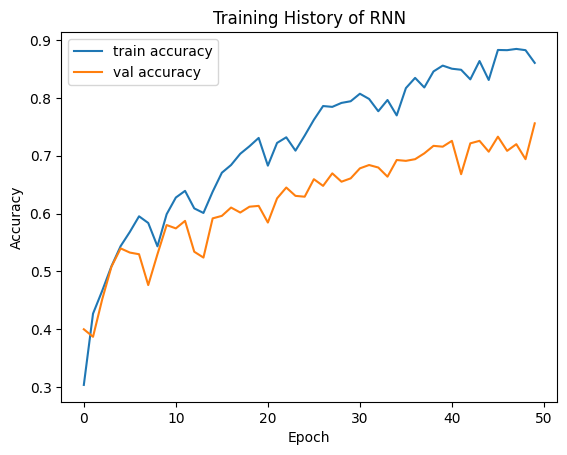

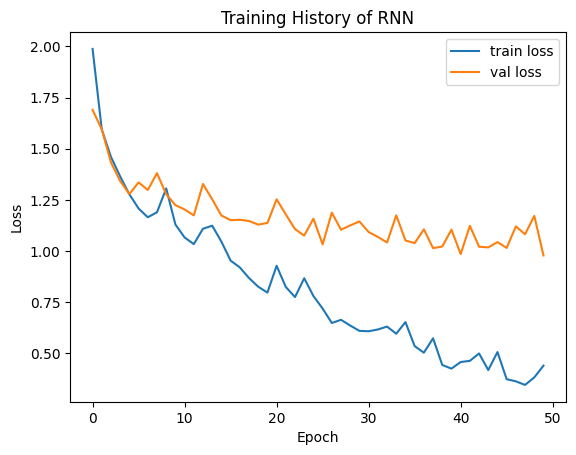

In [114]:
plt.plot(history_rnn["accuracy"], label="train accuracy")
plt.plot(history_rnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()

plt.plot(history_rnn["loss"], label="train loss")
plt.plot(history_rnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()

# Improved RNN

In [115]:
# Build improved RNN model
improved_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for music genres
])

# Compile improved model
improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [116]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train improved model
improved_history = improved_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate improved model
improved_loss, improved_accuracy = improved_model.evaluate(X_test, y_test)
print(f"Improved Test Loss: {improved_loss}")
print(f"Improved Test Accuracy: {improved_accuracy}")

Epoch 1/50


87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.1476 - loss: 3.5784 - val_accuracy: 0.2958 - val_loss: 2.6823 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.2009 - loss: 2.9705 - val_accuracy: 0.3405 - val_loss: 2.4246 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.2678 - loss: 2.6834 - val_accuracy: 0.3925 - val_loss: 2.2515 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.2781 - loss: 2.5269 - val_accuracy: 0.3997 - val_loss: 2.1352 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.2863 - loss: 2.4550 - val_accuracy: 0.3939 - val_loss: 2.0978 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.3191 - loss: 2.3098 - val_accuracy: 0.3954 - val_loss: 2.0083 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.3194 - loss: 2.2840 - val_

In [117]:
history_rnn_improved = {"accuracy": improved_history.history["accuracy"],
                        "val_accuracy": improved_history.history["val_accuracy"],
                        "loss": improved_history.history["loss"],
                        "val_loss": improved_history.history["val_loss"]}

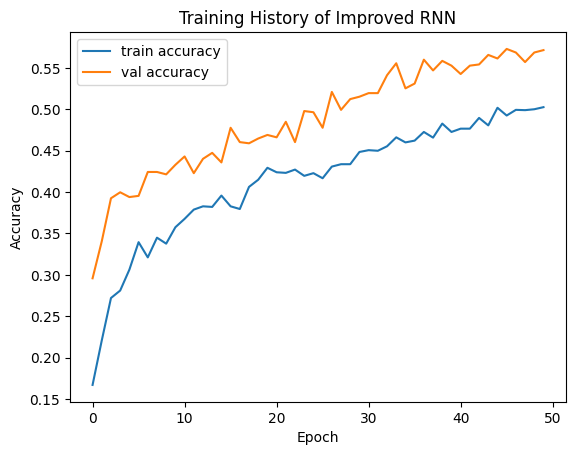

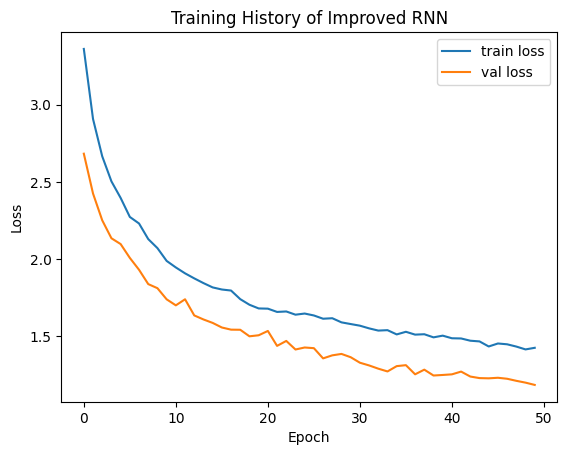

In [118]:
plt.plot(history_rnn_improved["accuracy"], label="train accuracy")
plt.plot(history_rnn_improved["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Improved RNN")
plt.legend()
plt.show()

plt.plot(history_rnn_improved["loss"], label="train loss")
plt.plot(history_rnn_improved["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Improved RNN")
plt.legend()
plt.show()

# Comparison

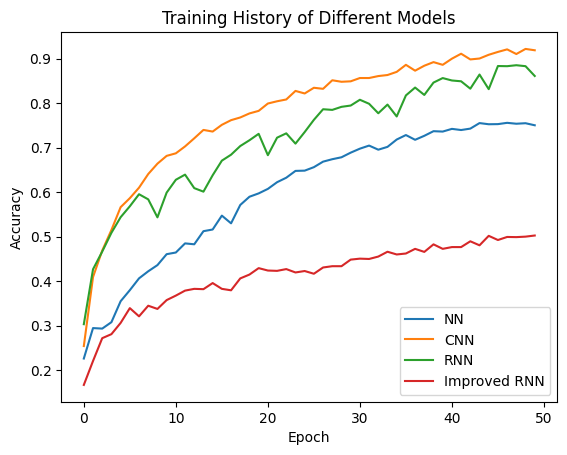

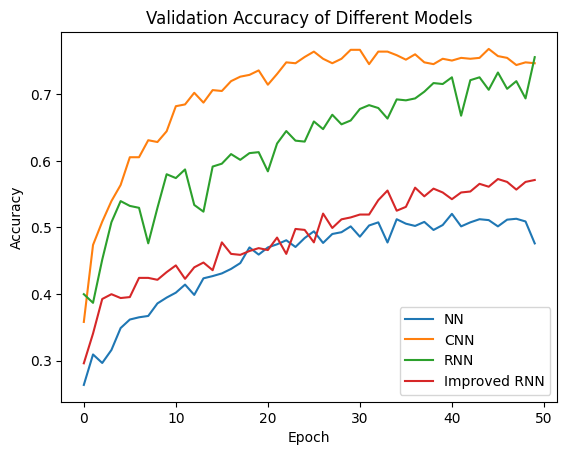

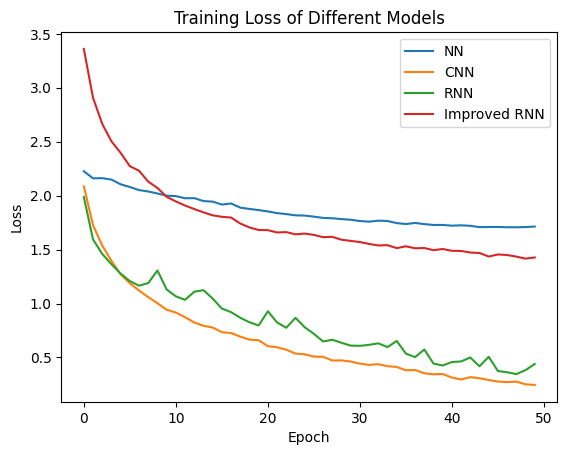

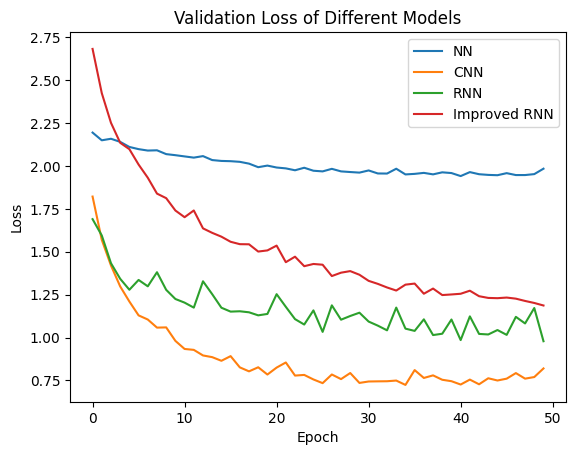

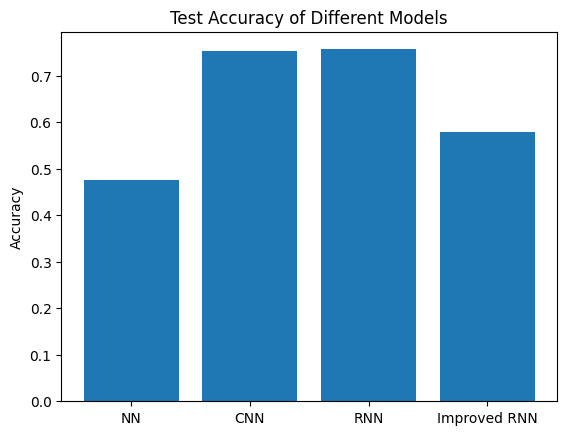

In [119]:
plt.plot(history_nn["accuracy"], label="NN")
plt.plot(history_cnn["accuracy"], label="CNN")
plt.plot(history_rnn["accuracy"], label="RNN")
plt.plot(history_rnn_improved["accuracy"], label="Improved RNN")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["val_accuracy"], label="NN")
plt.plot(history_cnn["val_accuracy"], label="CNN")
plt.plot(history_rnn["val_accuracy"], label="RNN")
plt.plot(history_rnn_improved["val_accuracy"], label="Improved RNN")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Validation Accuracy of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["loss"], label="NN")
plt.plot(history_cnn["loss"], label="CNN")
plt.plot(history_rnn["loss"], label="RNN")
plt.plot(history_rnn_improved["loss"], label="Improved RNN")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["val_loss"], label="NN")
plt.plot(history_cnn["val_loss"], label="CNN")
plt.plot(history_rnn["val_loss"], label="RNN")
plt.plot(history_rnn_improved["val_loss"], label="Improved RNN")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Validation Loss of Different Models")
plt.legend()
plt.show()

plt.bar(["NN", "CNN", "RNN", "Improved RNN"], [test_accuracy_nn, test_accuracy_cnn, model_accuracy, improved_accuracy])
plt.ylabel("Accuracy")
plt.title("Test Accuracy of Different Models")
plt.show()

